# Проект - Информационная безопасность

## Описание проекта

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика. Ваша задача - разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

В ходе работы вы пройдете все основные этапы полноценного исследования:\
🔸 загрузка и ознакомление с данными,\
🔸 предварительная обработка,\
🔸 полноценный разведочный анализ,\
🔸 разработка новых синтетических признаков,\
🔸 проверка на мультиколлинеарность,\
🔸 отбор финального набора обучающих признаков,\
🔸 выбор и обучение моделей,\
🔸 итоговая оценка качества предсказания лучшей модели,\
🔸 анализ важности ее признаков.

### Задача

🔸 Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный. При этом модель должна работать максимально качественно, так как цена ошибки может быть очень высока.\
🔸 Оценить качество модели по различным метрикам классификации: precision, recall, f1_score, accuracy.\
🔸 (*) Деплой: разработать REST API сервис, который будет принимать на вход данные трафика и возвращать класс этого трафика.\

### Этапы работы:

🔸 Вводный вебинар, постановка задачи\
🔸 Самостоятельная работа, проведение Stand-up, обсуждение результатов в канале\
🔸 Демонстрация результатов проекта

### Исходные данные

🔸 Ссылка на датасет - https://...

### План работы

**1. Знакомство с данными**

    1.1 Импорт библиотек
    
    1.2 Загрузка данных
    
    1.3 Исследовательский анализ данных (размер, признаки, строки, типы данных, пропуски, аномалии, дубликаты, кореляция, распределение)
    
 **2. Предобработка данных**
    
    2.1 Преобразование типов данных 
    
    2.2 Разбиение на выборки
    
    2.3 Нормализация значений
    
 **3. Обучение моделей**
 
 **4. Подготовка функции преобразование и сохранение модели в файл**
 
 **5. Вывод**

# Импорт библиотек и загрузка данных

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import warnings

from catboost import CatBoostClassifier
from catboost.utils import eval_metric

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay)
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
# settings for pandas
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
pd.options.display.float_format = '{:.2f}'.format
#pd.options.mode.chained_assignment = None

# warnings
warnings.filterwarnings("ignore")
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [4]:
df = pd.read_csv('data\\network_traffic_data.csv')

## Анализ данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

**Описание столбцов:**\
`destination_port` - Порт назначения указывает на конечный порт, к которому отправляются пакеты или установлено соединение.\
`flow_duration` - Продолжительность потока отражает время в миллисекундах, которое затратилось на передачу потока.\
`total_fwd_packets` - Общее количество прямых пакетов - это сумма всех пакетов, передаваемых в прямом направлении.\
`total_backward_packets` - Общее количество обратных пакетов - это сумма всех пакетов, передаваемых в обратном направлении.\
`total_length_of_fwd_packets` - Общая длина прямых пакетов показывает общую длину в байтах всех пакетов, передаваемых в прямом направлении.\
`total_length_of_bwd_packets` - Общая длина обратных пакетов показывает общую длину в байтах всех пакетов, передаваемых в обратном направлении.\
`fwd_packet_length_max` - Максимальная длина прямого пакета - это наибольшая длина в байтах среди всех прямых пакетов.\
`fwd_packet_length_min` - Минимальная длина прямого пакета - это наименьшая длина в байтах среди всех прямых пакетов.\
`fwd_packet_length_mean` - Средняя длина прямого пакета - это среднее значение длин в байтах среди всех прямых пакетов.\
`fwd_packet_length_std` - Стандартное отклонение длины прямого пакета - это мера разброса значений длин прямых пакетов относительно их среднего значения.\
`bwd_packet_length_max` - Максимальная длина обратного пакета - это наибольшая длина в байтах среди всех обратных пакетов.\
`bwd_packet_length_min` - Минимальная длина обратного пакета - это наименьшая длина в байтах среди всех обратных пакетов.\
`bwd_packet_length_mean` - Средняя длина обратного пакета - это среднее значение длин в байтах среди всех обратных пакетов.\
`bwd_packet_length_std` - Стандартное отклонение длин обратных пакетов указывает на разброс значений длин обратных пакетов относительно их среднего значения.\
`flow_bytes/s` - Байты потока в секунду показывают сколько байтов передается в сети за одну секунду.\
`flow_packets/s` - Пакеты потока в секунду показывают сколько пакетов передается в сети за одну секунду.\
`flow_iat_mean` - Среднее значение интервала между пакетами потока отражает среднее время, затраченное на передачу пакетов потока.\
`flow_iat_std` - Стандартное отклонение интервала между пакетами потока является мерой разброса значений интервалов между пакетами потока относительно их среднего значения.\
`flow_iat_max` - Наибольший интервал между пакетами потока показывает максимальное время между прибытием пакетов потока.\
`flow_iat_min` - Наименьший интервал между пакетами потока показывает минимальное время между прибытием пакетов потока.\
`fwd_iat_total`- Общий интервал между прямыми пакетами обозначает суммарное время между отправкой прямых пакетов.\
`fwd_iat_mean` - Средний интервал между прямыми пакетами показывает среднее время между отправкой прямых пакетов.\
`fwd_iat_std` - Стандартное отклонение интервала между прямыми пакетами является мерой разброса значений интервалов между прямыми пакетами относительно их среднего значения.\
`fwd_iat_max` - Наибольший интервал между прямыми пакетами показывает максимальное время между отправкой прямых пакетов.\
`fwd_iat_min` - Наименьший интервал между прямыми пакетами показывает минимальное время между отправкой прямых пакетов.\
`bwd_iat_total` - Общий интервал между обратными пакетами обозначает суммарное время между отправкой обратных пакетов.\
`bwd_iat_mean` - Средний интервал между обратными пакетами показывает среднее время между отправкой обратных пакетов.\
`bwd_iat_std` - Стандартное отклонение интервала между обратными пакетами является мерой разброса значений интервалов между обратными пакетами относительно их среднего значения.\
`bwd_iat_max` - Наибольший интервал между обратными пакетами показывает максимальное время между отправкой обратных пакетов.\
`bwd_iat_min` - Наименьший интервал между обратными пакетами показывает минимальное время между отправкой обратных пакетов.\
`fwd_psh_flags` - Флаги Push прямых пакетов обозначают пакеты, которые требуют моментальной передачи данных на приемную сторону без буферизации.\
`bwd_psh_flags` - Флаги Push обратных пакетов обозначают пакеты, которые требуют моментальной передачи данных на отправную сторону без буферизации.\
`fwd_urg_flags` - Флаги Urgent прямых пакетов обозначают пакеты, которые имеют высокий приоритет и требуют немедленной обработки.\
`bwd_urg_flags` - Флаги Urgent обратных пакетов обозначают пакеты, которые имеют высокий приоритет и требуют немедленной обработки.\
`fwd_header_length` - Длина заголовков прямых пакетов показывает размер заголовков прямых пакетов в байтах.\
`bwd_header_length` - Длина заголовков обратных пакетов показывает размер заголовков обратных пакетов в байтах.\
`fwd_packets/s` - Прямые пакеты в секунду показывают сколько прямых пакетов передается в сети за одну секунду.\
`bwd_packets/s` - Обратные пакеты в секунду показывают сколько обратных пакетов передается в сети за одну секунду.\
`min_packet_length` - Минимальная длина пакета указывает на наименьшую длину пакета в байтах.\
`max_packet_length` - Максимальная длина пакета указывает на наибольшую длину пакета в байтах.\
`packet_length_mean` - Средняя длина пакета представляет собой среднее значение длин всех пакетов в байтах.\
`packet_length_std` - Стандартное отклонение длины пакета показывает степень изменчивости длин всех пакетов относительно их среднего значения.\
`packet_length_variance` - Дисперсия длины пакета является мерой разброса значений длин пакетов относительно их среднего значения.\
`fin_flag_count` - Количество пакетов с флагом FIN указывает на количество пакетов, в которых установлен флаг FIN.\
`syn_flag_count` - Количество пакетов с флагом SYN указывает на количество пакетов, в которых установлен флаг SYN.\
`rst_flag_count` - Количество пакетов с флагом RST указывает на количество пакетов, в которых установлен флаг RST.\
`psh_flag_count` - Количество пакетов с флагом PSH указывает на количество пакетов, в которых установлен флаг PSH.\
`ack_flag_count` - Количество пакетов с флагом ACK указывает на количество пакетов, в которых установлен флаг ACK.\
`urg_flag_count` - Количество пакетов с флагом URG указывает на количество пакетов, в которых установлен флаг URG.\
`cwe_flag_count` - Количество пакетов с флагом CWE указывает на количество пакетов, в которых установлен флаг CWE.\
`ece_flag_count` - Количество пакетов с флагом ECE указывает на количество пакетов, в которых установлен флаг ECE.\
`down/up_ratio` - Отношение загрузки "скачать/отправить" представляет собой соотношение количества пакетов в сторону загрузки (скачивания) к количеству пакетов в сторону отправки.\
`average_packet_size` - Средний размер пакета указывает на среднюю длину пакета в байтах.\
`avg_fwd_segment_size` - Средний размер прямого сегмента представляет собой среднюю длину прямого сегмента в байтах.\
`avg_bwd_segment_size` - Средний размер обратного сегмента представляет собой среднюю длину обратного сегмента в байтах.\
`fwd_header_length.1` - Длина заголовка прямого пакета указывает на размер заголовка прямого пакета в байтах.\
`fwd_avg_bytes/bulk` - Среднее количество байт в пакете прямого потока представляет собой среднее количество байт в каждом пакете прямого потока.\
`fwd_avg_packets/bulk` - Среднее количество пакетов в прямом потоке представляет собой среднее количество пакетов в каждом прямом потоке.\
`fwd_avg_bulk_rate` - Средняя скорость передачи блоков в прямом направлении указывает на среднюю скорость передачи блоков данных в прямом направлении.\
`bwd_avg_bytes/bulk` - Среднее количество байт в блоке в обратном направлении показывает среднее количество байтов в каждом блоке данных в обратном направлении.\
`bwd_avg_packets/bulk` - Среднее количество пакетов в блоке в обратном направлении показывает среднее количество пакетов в каждом блоке данных в обратном направлении.\
`bwd_avg_bulk_rate` - Средняя скорость передачи блоков в обратном направлении указывает на среднюю скорость передачи блоков данных в обратном направлении.\
`subflow_fwd_packets` - Количество пакетов в подпотоке в прямом направлении показывает количество пакетов, передаваемых в подпотоке в прямом направлении.\
`subflow_fwd_bytes` - Количество байтов в подпотоке в прямом направлении показывает количество байтов, передаваемых в подпотоке в прямом направлении.\
`subflow_bwd_packets` - Количество пакетов в подпотоке в обратном направлении показывает количество пакетов, передаваемых в подпотоке в обратном направлении.\
`subflow_bwd_bytes` - Количество байтов в подпотоке в обратном направлении показывает количество байтов, передаваемых в подпотоке в обратном направлении.\
`init_win_bytes_forward` - Начальный размер окна приема в байтах в прямом направлении указывает на начальный размер окна приема данных в байтах в прямом направлении.\
`init_win_bytes_backward` - Начальный размер окна приема в байтах в обратном направлении указывает на начальный размер окна приема данных в байтах в обратном направлении.\
`act_data_pkt_fwd` - Количество активных прямых пакетов данных показывает количество активных прямых пакетов передачи данных.\
`min_seg_size_forward` - Минимальный размер сегмента в прямом направлении указывает на минимальный размер сегмента данных в прямом направлении.\
`active_mean` - Среднее значение активных соединений показывает среднее количество активных соединений в сети.\
`active_std` - Стандартное отклонение активных соединений указывает на степень изменчивости активных соединений относительно их среднего значения.\
`active_max` - Максимальное количество активных соединений показывает максимальное количество одновременно активных соединений в сети.\
`active_min` - Минимальное количество активных соединений показывает минимальное количество одновременно активных соединений в сети.\
`idle_mean` - Среднее значение простаивающих соединений показывает среднее количество простаивающих соединений в сети.\
`idle_std` - Стандартное отклонение простаивающих соединений указывает на степень изменчивости простаивающих соединений относительно их среднего значения.\
`idle_max` - Максимальное количество простаивающих соединений показывает максимальное количество одновременно простаивающих соединений в сети.\
`idle_min` - Минимальное количество простаивающих соединений показывает минимальное количество одновременно простаивающих соединений в сети.

79 столбцов по 539616 значений. Целевой признак Label.Явных пропусков нет. Типы данных соответствуют ожидаемым.

В данных есть столбцы с min max mean std возможно дополнительно генерировать признаки не потребуется

In [6]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,5480074,3,1,12,0,6,0,4.00,3.46,0,0,0.00,0.00,2.19,0.73,1826691.40,3131700.20,5442804,101,5480074,2740037.00,3822289.80,5442804,37270,0,0.00,0.00,0,0,0,0,0,0,72,32,0.55,0.18,0,6,2.40,3.29,10.80,0,0,0,1,0,0,0,0,0,3.00,4.00,0.00,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.10,103.30,1448,0,395.00,587.50,6535.32,26.69,39554.28,50154.62,120501,1,616301,77037.62,72995.98,215614,230,616874,68541.55,71985.97,199836,1,0,0,0,0,296,328,12.64,14.05,0,1448,232.60,442.80,196012.66,0,0,0,1,0,0,0,0,1,244.90,78.10,395.00,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.00,0.00,112,112,112.00,0.00,1981.77,26.08,51132.67,88558.31,153391,3,3,3.00,0.00,3,3,4,4.00,0.00,4,4,0,0,0,0,40,40,13.04,13.04,40,112,68.80,39.44,1555.20,0,0,0,0,0,0,0,0,1,86.00,40.00,112.00,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.00,0.00,128,128,128.00,0.00,3017.69,34.69,57660.00,0.00,57660,57660,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,17.34,17.34,46,128,73.30,47.34,2241.33,0,0,0,0,0,0,0,0,1,110.00,46.00,128.00,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.34,14.44,6,6,6.00,0.00,63885.27,5215.12,255.67,394.29,710,3,713,356.50,499.92,710,3,0,0.00,0.00,0,0,0,0,0,0,60,20,3911.34,1303.78,6,31,11.00,11.18,125.00,0,0,0,0,1,0,0,0,0,13.75,14.34,6.00,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.00,0.00,0,0,0.00,0.00,0,0,BENIGN


In [7]:
df.describe(include='all')

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539128.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616.00,539616
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BENIGN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240000
mean,5563.06,21066929.37,6.12,5.99,408.24,7999.78,169.45,11.86,44.68,59.53,1675.07,23.51,550.04,697.31,inf,inf,2134902.45,5264534.55,17318403.50,294558.36,20756340.18,4036797.30,6666492.26,17200410.93,1035760.29,9601754.01,2028745.22,2413091.18,6464188.15,814778.83,0.04,0.00,0.00,0.00,-4593.96,-4290.45,71421.49,7885.31,9.61,1723.70,276.58,544.09,1112687.62,0.06,0.04,0.00,0.38,0.37,0.06,0.00,0.00,0.64,305.36,44.68,550.04,-4593.96,0.00,0.00,0.00,0.00,0.00,0.00,6.12,408.24,5.99,7998.77,7564.76,1277.94,2.95,-2429.31,115498.42,40375.70,167288.24,89830.17,16101546.63,958564.89,16872266.93,15391495.53,NaN
std,14921.26,38121719.63,345.11,463.49,7478.35,1014441.80,560.53,60.96,150.87,217.73,2843.53,55.20,869.70,1255.31,NaN,NaN,5824584.75,10551103.82,33957014.03,4269410.12,38121061.80,10627587.74,13914086.55,34021535.79,8949950.83,28072181.79,9045625.35,8975672.92,21921965.46,7698886.82,0.19,0.00,0.01,0.00,2095355.38,207661

In [8]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

Есть значения inf заменим их

In [9]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [10]:
new_col_names = []
for column in df.columns:
    new_col_names.append(column.strip().replace(' ', '_').lower())

df.columns = new_col_names

In [11]:
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

Проверим на дубликаты и удалим их

In [12]:
print(f'До {df.shape}')
print(f'Обнаружено дубликатов: {df.duplicated().sum()}')
df = df.drop_duplicates()
print(f'После: {df.shape}')

До (539616, 79)


Обнаружено дубликатов: 64601
После: (475015, 79)


Удалим столбцы с одинковыми значениями

In [13]:
print(f'До: {df.shape}')
# Проверить все столбцы на наличие одинаковых значений
for column in df.columns:
    if df[column].drop_duplicates().shape[0] == 1:
        df = df.drop(column, axis=1)
print(f'После: {df.shape}')

До: (475015, 79)
После: (475015, 71)


EDA проведем с помощью библиотеки SweetViz

In [14]:
#report = sv.analyze(df)
#report.show_html('common analysis.html')

## destination_port

Порт назначения - порт на который отправляется пакет. 

In [15]:
df['destination_port'].describe()

count   475015.00
mean      5871.02
std      15516.41
min          0.00
25%         80.00
50%         80.00
75%        443.00
max      65533.00
Name: destination_port, dtype: float64

Официально порт 0 не существует, и к нему нельзя подключиться. Однако можно отправлять интернет-пакет на порт 0

In [16]:
df['destination_port'].value_counts().head(10)

destination_port
80      198897
53       99170
443      50896
21        6517
22        4342
123       2390
8080      1455
389        715
88         603
465        417
Name: count, dtype: int64

In [17]:
set(df.query('label != "BENIGN"')['destination_port'].value_counts().head(5))

{118, 1313, 3359, 6062, 174833}

Обычные порты используемые в сетях. Возможно частота некоторых интуитвно не должна быть такой высокой, но назначение сети мы не знаем.

Из топ портов для атак выпадает 53 порт, зарезервированный для использования с DNS-серверами. Также в топ попадают следующие порты

In [18]:
set(df.query('label != "BENIGN"')['destination_port'].value_counts().head(10).index) - \
set(df['destination_port'].value_counts().head(10).index)

{139, 444, 445, 587, 6779}

23 - Telnet (протокол удаленного терминала)\
139 - Порт 139 используется для общего доступа к файлам и принтерам, это единственный наиболее опасный порт потому, что оставляет жесткий диск пользователя незащищенным\
444 - SNMP протокол для управления устройствами в IP-сетях(маршрутизаторы, коммутаторы, серверы, рабочие станции, принтеры, модемные стойки и другие)\
5432 - PostgreSQL database\
6779 - обычный tcp/udp

Порт будем обрабатывать как категориальную переменную

In [19]:
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'fwd_urg_flags',
       'fwd_header_length', 'bwd_header_length', 'fwd_packets/s',
       'bwd_packets/s', 'min_packet_length', 'max_packet_length',
       'packet_length_mean', 'packet_length_std', 'packet_length_variance',
       'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count',

In [20]:
labels = {}
for num, i in enumerate(df['label'].unique()):
    labels[i] = num

labels

{'BENIGN': 0,
 'PortScan': 1,
 'DoS Hulk': 2,
 'DDoS': 3,
 'Bot': 4,
 'Infiltration': 5,
 'Web Attack � Brute Force': 6,
 'Web Attack � XSS': 7,
 'Web Attack � Sql Injection': 8,
 'FTP-Patator': 9,
 'SSH-Patator': 10,
 'DoS slowloris': 11,
 'DoS Slowhttptest': 12,
 'DoS GoldenEye': 13,
 'Heartbleed': 14}

In [21]:
df['label'] = df['label'].map(labels)

In [22]:
(df < 0).sum().sort_values(ascending=False)

init_win_bytes_backward        168538
init_win_bytes_forward         103039
flow_iat_min                      402
flow_iat_max                       19
flow_iat_mean                      19
flow_duration                      19
flow_packets/s                     19
flow_bytes/s                       15
fwd_iat_min                         8
min_seg_size_forward                5
fwd_header_length                   5
bwd_header_length                   5
fwd_header_length.1                 5
urg_flag_count                      0
cwe_flag_count                      0
avg_bwd_segment_size                0
ack_flag_count                      0
psh_flag_count                      0
ece_flag_count                      0
rst_flag_count                      0
syn_flag_count                      0
down/up_ratio                       0
average_packet_size                 0
avg_fwd_segment_size                0
destination_port                    0
subflow_bwd_packets                 0
subflow_fwd_

In [23]:
df.isna().sum()

destination_port                 0
flow_duration                    0
total_fwd_packets                0
total_backward_packets           0
total_length_of_fwd_packets      0
total_length_of_bwd_packets      0
fwd_packet_length_max            0
fwd_packet_length_min            0
fwd_packet_length_mean           0
fwd_packet_length_std            0
bwd_packet_length_max            0
bwd_packet_length_min            0
bwd_packet_length_mean           0
bwd_packet_length_std            0
flow_bytes/s                   262
flow_packets/s                 262
flow_iat_mean                    0
flow_iat_std                     0
flow_iat_max                     0
flow_iat_min                     0
fwd_iat_total                    0
fwd_iat_mean                     0
fwd_iat_std                      0
fwd_iat_max                      0
fwd_iat_min                      0
bwd_iat_total                    0
bwd_iat_mean                     0
bwd_iat_std                      0
bwd_iat_max         

Отрицательные значения не должны встречаться судя по описанию данных. Предположительно, учитывая количество отрицательных значений и количество NaN в датасете, отрицательными значениями заменены пропуски

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 475015 entries, 0 to 539615
Data columns (total 71 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             475015 non-null  int64  
 1   flow_duration                475015 non-null  int64  
 2   total_fwd_packets            475015 non-null  int64  
 3   total_backward_packets       475015 non-null  int64  
 4   total_length_of_fwd_packets  475015 non-null  int64  
 5   total_length_of_bwd_packets  475015 non-null  int64  
 6   fwd_packet_length_max        475015 non-null  int64  
 7   fwd_packet_length_min        475015 non-null  int64  
 8   fwd_packet_length_mean       475015 non-null  float64
 9   fwd_packet_length_std        475015 non-null  float64
 10  bwd_packet_length_max        475015 non-null  int64  
 11  bwd_packet_length_min        475015 non-null  int64  
 12  bwd_packet_length_mean       475015 non-null  float64
 13  bwd_

# Model

In [25]:
%time

df.fillna(-1, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

X, y = df.drop('label', axis=1), df['label'] 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=df['label']
    )

print('Обучающая выборка:')
print('Доля от общего размера:', round(y_train.shape[0]/X.shape[0], 2))
print('Cтрок, столбцов:', X_train.shape)
print('Доля целевого признака:', round(y_train.mean(), 3))
print('- '*10)


print('Тестовая выборка:')
print('Доля от общего размера:', round(y_test.shape[0]/X.shape[0], 2))
print('Cтрок, столбцов:', X_test.shape)
print('Доля целевого признака:', round(y_test.mean(), 3))
print('-'*30)

CPU times: total: 0 ns
Wall time: 0 ns


Обучающая выборка:
Доля от общего размера: 0.8
Cтрок, столбцов: (380012, 70)
Доля целевого признака: 1.657
- - - - - - - - - - 
Тестовая выборка:
Доля от общего размера: 0.2
Cтрок, столбцов: (95003, 70)
Доля целевого признака: 1.657
------------------------------


In [26]:
#categorical = list(X_train.select_dtypes('object').columns)
categorical = ['destination_port']
print(f"Категориальные признаки: {categorical}")

numerical = list(set(X_train.select_dtypes('number').columns) - set(categorical))
print(f"Числовые признаки: {numerical}")

Категориальные признаки: ['destination_port']


Числовые признаки: ['ack_flag_count', 'subflow_bwd_packets', 'fwd_iat_std', 'packet_length_variance', 'active_max', 'init_win_bytes_backward', 'fwd_packets/s', 'flow_iat_min', 'bwd_iat_std', 'fwd_header_length.1', 'avg_fwd_segment_size', 'packet_length_std', 'act_data_pkt_fwd', 'idle_mean', 'ece_flag_count', 'bwd_iat_max', 'fwd_psh_flags', 'idle_max', 'total_fwd_packets', 'idle_min', 'min_packet_length', 'fwd_packet_length_min', 'flow_bytes/s', 'active_mean', 'syn_flag_count', 'active_std', 'total_length_of_bwd_packets', 'bwd_header_length', 'fwd_packet_length_max', 'bwd_iat_min', 'min_seg_size_forward', 'subflow_bwd_bytes', 'down/up_ratio', 'subflow_fwd_packets', 'idle_std', 'flow_iat_mean', 'subflow_fwd_bytes', 'max_packet_length', 'fin_flag_count', 'fwd_header_length', 'fwd_urg_flags', 'cwe_flag_count', 'packet_length_mean', 'urg_flag_count', 'bwd_packet_length_std', 'flow_duration', 'avg_bwd_segment_size', 'fwd_iat_mean', 'psh_flag_count', 'fwd_packet_length_mean', 'active_min', 'f

In [27]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, Normalizer

In [35]:
cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])
num_pipe = Pipeline([('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
    [
        ('cat', cat_pipe, categorical),
        ('num', num_pipe, numerical),  # 0.888529
    ], remainder='passthrough')

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("regressor", XGBClassifier)
    ]
)

param_grid = [{'regressor': [XGBClassifier(
    random_seed=RANDOM_STATE, 
    objective='multi:softmax')],
    'regressor__maxdepth': range(5, 8, 1),
    }]

grid = RandomizedSearchCV(pipe, param_grid, n_iter=3,
                          cv=5, scoring='f1_macro', verbose=3, random_state=RANDOM_STATE, n_jobs=1)

In [36]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END regressor=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...), regressor__maxdepth=5;, score=0.933 total time= 1.2min
[CV 2/5] END regressor=XGBClassifier(base_score=None, booster=None, callbacks=None,
           

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['destination_port']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['ack_flag_count',
                                                                                'subflow_bwd_packets',
                                                                                'fwd_iat_std',
                                                                                'packet_length_variance',...
                                                                     max_bin=None,
                                                                     max_cat_threshold=None,
                                                                     max_cat_to_onehot=None,
                                                                     max_delta_step=None,
                                                                     max_depth=None,
                                                                     max_leaves=None,
                                                                     min_child_weight=None,
                                                                     missing=nan,
                                                                     monotone_constraints=None,
                                                                     multi_strategy=None,
                                                                     n_estimators=None,
                                                                     n_jobs=None,
                                                                     num_parallel_tree=None,
                                                                     objective='multi:softmax', ...)],
                                         'regressor__maxdepth': range(5, 8)}],
                   random_state=42, scoring='f1_macro', verbose=3)

In [37]:
result = pd.DataFrame(grid.cv_results_)
result.sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__maxdepth,param_regressor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,73.72,1.72,2.35,0.27,5,"XGBClassifier(base_score=None, booster=None, c...","{'regressor__maxdepth': 5, 'regressor': XGBCla...",0.93,0.92,0.92,0.90,0.90,0.92,0.01,1
1,79.37,1.64,2.48,0.11,6,"XGBClassifier(base_score=None, booster=None, c...","{'regressor__maxdepth': 6, 'regressor': XGBCla...",0.93,0.92,0.92,0.90,0.90,0.92,0.01,1
2,72.31,3.92,2.36,0.36,7,"XGBClassifier(base_score=None, booster=None, c...","{'regressor__maxdepth': 7, 'regressor': XGBCla...",0.93,0.92,0.92,0.90,0.90,0.92,0.01,1


In [38]:
#target_names = list(label_encoder.inverse_transform(df['label'].unique()))

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46562
           1       1.00      1.00      1.00     11279
           2       1.00      1.00      1.00     17450
           3       1.00      1.00      1.00     12873
           4       0.94      0.97      0.96       391
           5       1.00      1.00      1.00         7
           6       0.74      0.86      0.79       294
           7       0.53      0.32      0.40       130
           8       0.75      0.75      0.75         4
           9       1.00      1.00      1.00      1187
          10       1.00      1.00      1.00       644
          11       1.00      0.99      1.00      1077
          12       1.00      1.00      1.00      1046
          13       1.00      1.00      1.00      2057
          14       1.00      1.00      1.00         2

    accuracy                           1.00     95003
   macro avg       0.93      0.93      0.93     95003
weighted avg       1.00   

<Figure size 1440x1440 with 0 Axes>

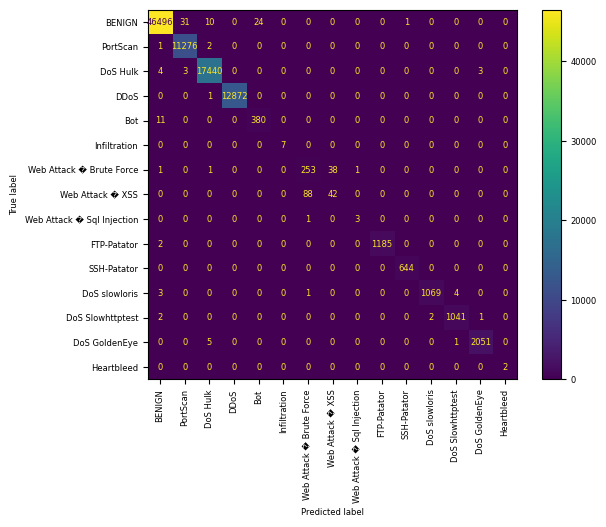

In [39]:
conf_matr = confusion_matrix(y_test, y_pred)

plt.rc('font', size=6) #controls default text size
plt.figure(figsize=(12, 12), dpi=120)
ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=labels.keys()).plot()
plt.xticks(rotation=90)
plt.show();

Модель относительно не плохо определила класс атак. Наибольшая ошибка между классами Web Attack. При этом сам факт атаки чаще всего ошибочно определеяется при определениии ботов (Bot)

In [ ]:
#%pip freeze > requirements.txt

# Вывод

В данной работе нами проведено исследование датасета с логами сетевых параметров при работе различных сетевых атак. На основе данного датасета была построена модель опредееления типа атаки на основе модели градиентного бустинга XGBClassifier.

В датасете обнаружены столбцы со средними, минимальными, максимальными значениями, можно предположить что данных избыточно и генерация "фичей" не понадобится.
На этапе предварительного ознакомления в датасете выявлено 79 столбцов. В дальнейшем из-за того что столбец заполнен одинковыми значениями 8 столбцов были удалены.
Также были удалены дубликаты. 

Порт на который отправляются пакеты было решено использовать как категориальный признак.

На основе XGBClassifier был собран pipeline со случайным подбором гиперпараметров RandomSearchCV
После обучения при тестировании на тестовой выборке получен резйльтат с метрики F1 0.93

Параметры используемой модели  приведены ниже

In [41]:
grid.best_estimator_.named_steps["regressor"].get_xgb_params()

{'objective': 'multi:softmax',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'eval_metric': None,
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'random_seed': 42,
 'maxdepth': 5}